In [11]:
import os
import numpy as np
import librosa
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, GroupKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [12]:
warnings.filterwarnings("ignore", category=UserWarning)

DATASET_ROOT = "/kaggle/input/esc10rearranged/Data"

SAMPLE_RATE = 16000
AUDIO_LENGTH = SAMPLE_RATE * 5

N_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 64

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set(style="whitegrid")

In [13]:
def pad_or_truncate(signal, target_len):
    if len(signal) >= target_len:
        return signal[:target_len]
    return np.pad(signal, (0, target_len - len(signal)), mode="constant")


def augment_audio(y, sr):
    augmented = [y]

    augmented.append(pad_or_truncate(
        librosa.effects.time_stretch(y, rate=0.95),
        AUDIO_LENGTH
    ))

    augmented.append(pad_or_truncate(
        librosa.effects.pitch_shift(y, sr=sr, n_steps=1),
        AUDIO_LENGTH
    ))

    noise = 0.003 * np.random.randn(len(y))
    augmented.append(pad_or_truncate(y + noise, AUDIO_LENGTH))

    return augmented

In [14]:
def extract_features(y, sr):
    y = pad_or_truncate(y, AUDIO_LENGTH)

    mfcc = librosa.feature.mfcc(
        y=y, sr=sr, n_mfcc=N_MFCC,
        n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS
    )

    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)

    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=N_FFT)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=N_FFT)
    zcr = librosa.feature.zero_crossing_rate(y)
    rms = librosa.feature.rms(y=y)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=N_FFT)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=N_FFT)

    features = np.vstack([
        mfcc, delta, delta2,
        chroma, contrast,
        zcr, rms, rolloff, bandwidth
    ])

    return np.hstack([np.mean(features, axis=1), np.std(features, axis=1)])

In [15]:
X, y, groups = [], [], []

classes = sorted(os.listdir(DATASET_ROOT))

for label, class_name in enumerate(classes):
    class_path = os.path.join(DATASET_ROOT, class_name)

    for file_id, fname in enumerate(os.listdir(class_path)):
        if fname.endswith(".wav"):
            path = os.path.join(class_path, fname)
            audio, sr = librosa.load(path, sr=SAMPLE_RATE, mono=True)

            for sig in augment_audio(audio, sr):
                X.append(extract_features(sig, sr))
                y.append(label)
                groups.append(f"{class_name}_{file_id}")

X = np.array(X)
y = np.array(y)
groups = np.array(groups)

print("Dataset shape:", X.shape)
print("Classes:", classes)

Dataset shape: (1600, 124)
Classes: ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog', 'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing']


In [16]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.98, random_state=RANDOM_STATE)),
    ("svm", SVC(
        kernel="rbf",
        class_weight="balanced",
        probability=True,
        random_state=RANDOM_STATE
    ))
])

param_grid = {
    "svm__C": [5, 10, 50, 100],
    "svm__gamma": ["scale", 0.01]
}

cv = GroupKFold(n_splits=5)

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1
)

grid.fit(X, y, groups=groups)

print("Best parameters:", grid.best_params_)

Best parameters: {'svm__C': 10, 'svm__gamma': 0.01}


In [17]:
y_pred = cross_val_predict(
    grid.best_estimator_,
    X, y,
    cv=cv,
    groups=groups,
    method="predict"
)

y_proba = cross_val_predict(
    grid.best_estimator_,
    X, y,
    cv=cv,
    groups=groups,
    method="predict_proba"
)

print(classification_report(y, y_pred, target_names=classes))

                precision    recall  f1-score   support

      chainsaw       0.95      0.92      0.93       160
    clock_tick       0.74      0.86      0.80       160
crackling_fire       0.82      0.84      0.83       160
   crying_baby       0.97      0.90      0.93       160
           dog       0.87      0.81      0.84       160
    helicopter       0.87      0.87      0.87       160
          rain       0.92      0.85      0.88       160
       rooster       0.95      0.94      0.95       160
     sea_waves       0.91      0.89      0.90       160
      sneezing       0.83      0.91      0.87       160

      accuracy                           0.88      1600
     macro avg       0.88      0.88      0.88      1600
  weighted avg       0.88      0.88      0.88      1600



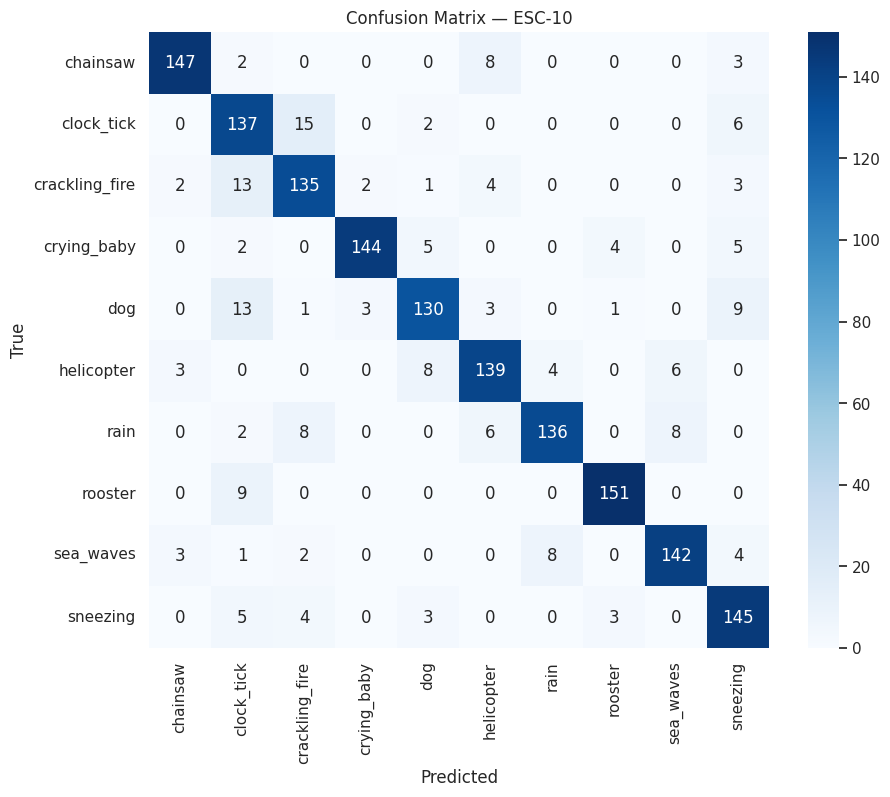

In [18]:
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)
plt.title("Confusion Matrix — ESC-10")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

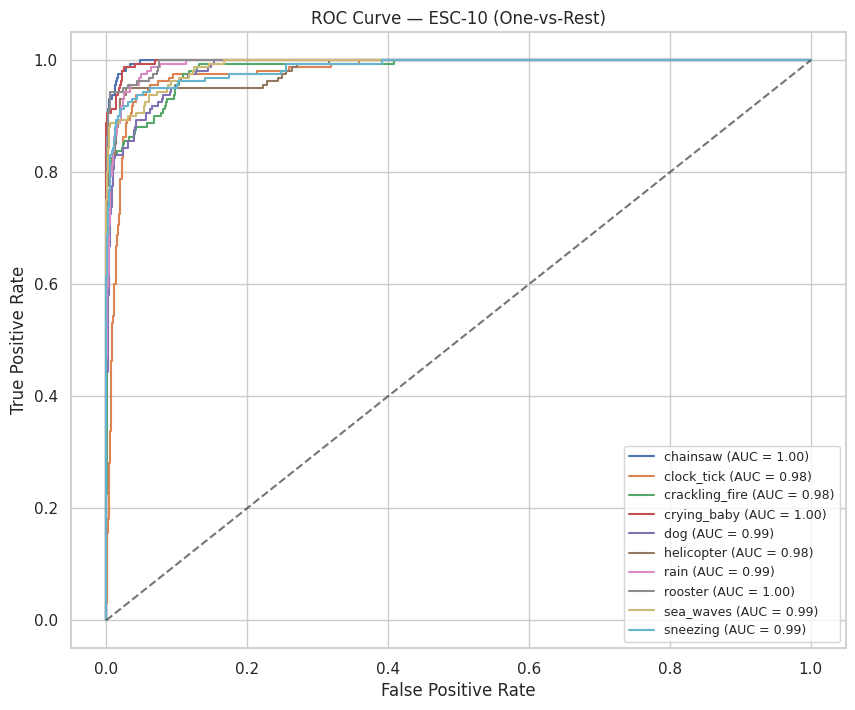

In [19]:
y_bin = label_binarize(y, classes=range(len(classes)))

plt.figure(figsize=(10, 8))

for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(
        fpr, tpr,
        label=f"{class_name} (AUC = {roc_auc:.2f})"
    )

plt.plot([0, 1], [0, 1], "k--", alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — ESC-10 (One-vs-Rest)")
plt.legend(loc="lower right", fontsize=9)
plt.show()